In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

/Users/debrastern/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from sklearn.metrics import roc_auc_score

In [4]:
raw = pd.read_csv('../jsons/very_clean_data.csv')

The first model that I will be fitting is a Logistic Regression. Compared to other classification models, Logistic Regression is relatively computationally inexpensive, and can result in very interpretable (and relevant) results. 

In [5]:
tfidf = TfidfVectorizer(stop_words='english', min_df=3, max_df=1.0,max_features=12000, ngram_range=(1,4))

Before the fitting step can occur, I have to transform the data into a format that can be understood by the model.

I will be using the TFIDF Vectorizer for this model, which transforms the dataset into a vector containing individual words as columns, with their "Inverse Document Frequency" as the values pertaining to each word/column.

According to the SKLearn documentation, the TFIDF Vectorizer is equivalent to running CountVectorizer, followed by TFIDFTransformer.

In [6]:
X = raw['text']
y = raw['target']

In [7]:
X = tfidf.fit_transform(X)

In [8]:
X = pd.SparseDataFrame(X, columns=tfidf.get_feature_names())
X.fillna(0,inplace=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [10]:
lr = LogisticRegression(random_state=420,class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=420,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
lr_predict = lr.predict(X_test)

Since we have unbalanced classes, I am going to use 'precision' as the prefered scoring metric. Precision is defined as "the fraction of relevant instances among the retrieved instances." [source: wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall "wikipedia")

In [12]:
lr_cv_score = cross_val_score(lr, X, y, cv=5, scoring='precision')

## Confusion Matrix



Classification results are frequently displayed via a _confusion matrix_, which lists the True Positives, True Negatives, False Positives and False Negatives 

![Confusion Matrix Diagram](../images/confusionmatrix.jpg)

For this use case, we will be looking to maximize the values in the bottom right corner (True Positives), while limiting the results of the top right corner (False Positives).

In [13]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, lr_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, lr_predict))
print('\n')
print("=== All Precision Scores ===")
print(lr_cv_score)
print('\n')
print("=== Mean Precision Score ===")
print("Mean Precision Score - Logistic Regression: ", lr_cv_score.mean())

=== Confusion Matrix ===
[[ 3667  2035]
 [ 4914 10579]]


=== Classification Report ===
             precision    recall  f1-score   support

          0       0.43      0.64      0.51      5702
          1       0.84      0.68      0.75     15493

avg / total       0.73      0.67      0.69     21195



=== All Precision Scores ===
[0.8085048  0.82412762 0.82330789 0.81836839 0.81374145]


=== Mean Precision Score ===
Mean Precision Score - Logistic Regression:  0.8176100305261119


The mean, cross-validated precision score of 81.7 is not bad, as it is over the naive baseline.

Since we are optimizing for precision score, however it is probably better to set a confidence threshold for the model to declare something as the positive class (rather than the default of .5). 

Let's take a look at how the various metrics change, as the positive class confidence interval is adjusted.

In [16]:
lr_probas = lr.predict_proba(X_test)

### With the thresholds applied

In [15]:
pred_proba_df = pd.DataFrame(lr_probas)

In [18]:
precision_scores = []
accuracy_scores = []
auc_roc_scores = []
avg_precision_scores = []
recall_scores = []
true_poses = []
false_poses = []

Plot out how the model's scores change based on threshold level

Code inspired from: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn/28724763

In [19]:
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

for i in threshold_list:
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    
    first_part = y_test.as_matrix().reshape(y_test.as_matrix().size,1);
    second_part = y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1);
    
    prec_score = precision_score(first_part, second_part)
    precision_scores.append(prec_score)
    pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    acc_score = accuracy_score(first_part,second_part)
    accuracy_scores.append(acc_score)
    
    aucroc_score = roc_auc_score(first_part,second_part)
    auc_roc_scores.append(aucroc_score)
    
    avg_prec_score = average_precision_score(first_part,second_part)
    avg_precision_scores.append(avg_prec_score)
    
    rec_score = recall_score(first_part,second_part)
    recall_scores.append(rec_score)
    
    true_pos = confusion_matrix(first_part,second_part)[1][1]
    true_poses.append(true_pos)
    
    false_pos = confusion_matrix(first_part,second_part)[0][1]
    false_poses.append(false_pos)

C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sy

In [20]:
all_scores = {'thresholds': threshold_list, 
        'precision_scores': precision_scores, 
        'accuracy_scores': accuracy_scores,
       'auc_roc_scores': auc_roc_scores,
       'avg_precision_scores': avg_precision_scores,
             'recall_scores': recall_scores,
             'true_positives': true_poses,
             'false_positives': false_poses}

In [21]:
all_scores = pd.DataFrame(all_scores)

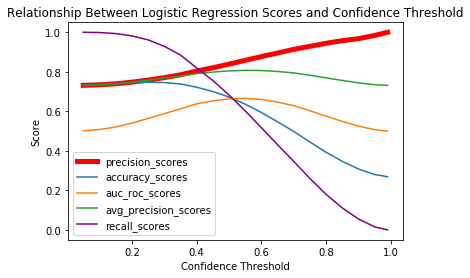

In [50]:
plt.plot('thresholds', 'precision_scores', data=all_scores, marker='', markerfacecolor='blue', markersize=10, color='red', linewidth=5)
plt.plot('thresholds', 'accuracy_scores', data=all_scores)
plt.plot('thresholds', 'auc_roc_scores', data=all_scores)
plt.plot('thresholds', 'avg_precision_scores', data=all_scores)
plt.plot('thresholds', 'recall_scores', data=all_scores,color='purple')
plt.title('Relationship Between Logistic Regression Scores and Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')

plt.legend()

Looks like precision is increasing in a somewhat linear manner, as the confidence threshold increases. This could be especially beneficial, since our goal is to optimize for precision. It is also interesting to note that the non-precision scores (accuracy, auc_roc and recall), all converge at about .5 confidence threshold.

Let's see how the confusion matrix/classification report changes if the threshold for positive class prediction was adjusted to > .85%.

In [23]:
y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>.85 else 0)
test_accuracy = accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
print('Our testing accuracy is {}'.format(test_accuracy))
print('\n')
print('Confusion Matrix:')
print('\n')
print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))
print('\n')
print(classification_report(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))

Our testing accuracy is 0.3471573484312338


Confusion Matrix:


[[ 5625    77]
 [13760  1733]]


              precision    recall  f1-score   support

           0       0.29      0.99      0.45      5702
           1       0.96      0.11      0.20     15493

   micro avg       0.35      0.35      0.35     21195
   macro avg       0.62      0.55      0.32     21195
weighted avg       0.78      0.35      0.27     21195



C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
C:\Users\16313\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\16313\Anaconda3\lib\

Adjusting the threshold had a great increase on Precision! It is now .96, with a 1733-to-77 difference in True Positives vs False Positives

In [17]:
pred_probas = pd.DataFrame(lr_probas)
y_test_labels = pd.DataFrame(y_test).reset_index()
preds_merged = pd.concat([pred_probas,y_test_labels],axis=1).set_index('index')
preds_with_orig = pd.concat([preds_merged,raw],axis=1)
preds_with_orig = preds_with_orig.dropna()
preds_with_orig.reset_index(inplace=True)
preds_with_orig.columns = ['label','LR_0','LR_1','target','target2','text']

Let's look at some posts that the LR classifier incorrectly classified.

In [28]:
preds_with_orig.loc[(preds_with_orig['target'] == 1) & (preds_with_orig['LR_1'] < .5)].sort_values('LR_1').head(20)

,label,LR_0,LR_1,target,target2,text
10114,40526,0.953879,0.046121,1.0,1,banjo solo
14022,56228,0.950262,0.049738,1.0,1,And best Christmas movie time
11341,45462,0.939187,0.060813,1.0,1,If liked Ocean love Ocean
12997,51996,0.938555,0.061445,1.0,1,All Halloween I ever seen first two Rob Zombie...
14274,57161,0.936698,0.063302,1.0,1,Love movie huge part childhood I watch every C...
3802,14821,0.936338,0.063662,1.0,1,Every Star Wars movie excluding episode After ...
10938,43923,0.931570,0.068430,1.0,1,'A Christmas Story'
13462,53918,0.920428,0.079572,1.0,1,Seinfeld season nothing happening one profitab...
9633,38468,0.919766,0.080234,1.0,1,I heard bad thing sequel I even watched I tryi...
9295,37025,0.916336,0.083664,1.0,1,Goal also pretty awful movie And sequel even w...


In [29]:
preds_with_orig.loc[14922]['text']

'Spielberg overrated schmalzmaker Here strong opinion movie'

Based on the top words discovered in EDA, a lot of these incorrect predictions make sense. "Christmas," "Speilberg" and "Sequel" in particular were listed as Top Words among flicks, which is likely why the posts above containing those words were incorrectly classified.

Let's save out these predictions, so that they can be compared with the predictions made by the other models, at a later stage.

In [26]:
preds_with_orig[['label','LR_0','LR_1','target']].to_csv('./jsons/LR_probas.csv',index=False)

In [52]:
orig_labels = preds_with_orig[['label', 'text']]

In [27]:
all_scores.to_csv('./jsons/LR_scores.csv')

In [54]:
orig_labels.to_csv('./jsons/text_labels.csv',index=False)

### Top Coefficients

In [28]:
lr.coef_

array([[ 0.40956267,  0.40800871, -0.35339364, ...,  2.30155237,
         0.79373083,  0.33626959]])

In [38]:
coeffs = pd.DataFrame(lr.coef_).T

In [42]:
coeffs['word'] = pd.Series(X.columns).T

In [49]:
coeffs.sort_values(0,ascending=False).head(10)

,0,word
53,2.670224,accessible
4417,2.663794,godard
4200,2.629622,french
5235,2.616986,individual
5386,2.552216,interpretation
7674,2.447564,ozu
5214,2.364931,independent
6656,2.329795,meaning
11997,2.301552,zoom
2632,2.291052,director


These coefficients make sense in the context of our assumptions about 'TrueFilm' users; "Godard", "french", "interpretation" and many others definitely seem like words that would be used by serious "film" fans, rather than more casual users. Indeed, the worst "accessible" is also often used to designate whether a movie likely to be enjoyed by a casual film-goer.

In [48]:
coeffs.sort_values(0,ascending=False).tail(20)

,0,word
10081,-2.019856,stereo
5362,-2.035750,interesting character
2621,-2.040002,dir
1277,-2.119989,cagney
4928,-2.123350,hologram
1371,-2.124737,cassius
7490,-2.153105,ocean
1324,-2.171426,captain
4161,-2.181587,fox
1606,-2.205196,christmas


These also make intuitive sense, based on assumptions about "flicks" posters, vs "TrueFilm".

It is interesting to note that "change view" and "cmv" were listed as the "most negative" coefficients, when it comes to classifying the positive class. These words are often found in recurring posts that only exist in 'flicks', and would probably be beneficial to remove outright, to futher tune the model.

This observation is also an example of how the data science/modeling process is non-linear.